In [8]:
import pickle

def count_records(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data.shape

train_total = count_records('data/next-day-wildfire-spread/train.data')
val_total = count_records('data/next-day-wildfire-spread/validation.data')
test_total = count_records('data/next-day-wildfire-spread/test.data')

total_records = train_total + val_total + test_total

print(f"Train records (raw):     {train_total}")
print(f"Validation records (raw):{val_total}")
print(f"Test records (raw):      {test_total}")
print(f"Total records (raw):     {total_records}")


Train records (raw):     (28000, 19, 64, 64)
Validation records (raw):(5333, 19, 64, 64)
Test records (raw):      (6000, 19, 64, 64)
Total records (raw):     (28000, 19, 64, 64, 5333, 19, 64, 64, 6000, 19, 64, 64)


In [9]:
print(f"Total records (raw):     {total_records[0]} rows, {total_records[1]} columns")
print(f"Total records (raw):     {total_records[0] * total_records[1]} total entries")
print(f"Total records (raw):     {total_records[0]} rows, {total_records[1]} columns, {total_records[0] * total_records[1]} total entries")


Total records (raw):     28000 rows, 19 columns
Total records (raw):     532000 total entries
Total records (raw):     28000 rows, 19 columns, 532000 total entries


In [10]:
import pickle
import numpy as np

def check_shape(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    

    if isinstance(data, np.ndarray):
        print(f"{file_path} → shape: {data.shape}")
        return data.shape
    elif isinstance(data, (list, tuple)):
        print(f"{file_path} → contains {len(data)} elements. First element shape: {np.array(data[0]).shape}")
        return len(data), np.array(data[0]).shape
    else:
        print(f"{file_path} → Unknown data type: {type(data)}")
        return None

train_shape = check_shape('data/next-day-wildfire-spread/train.data')
val_shape = check_shape('data/next-day-wildfire-spread/validation.data')
test_shape = check_shape('data/next-day-wildfire-spread/test.data')


data/next-day-wildfire-spread/train.data → shape: (28000, 19, 64, 64)
data/next-day-wildfire-spread/validation.data → shape: (5333, 19, 64, 64)
data/next-day-wildfire-spread/test.data → shape: (6000, 19, 64, 64)


DataFrame built with 500,000 rows | Fire=1: 7,080, No-Fire=0: 492,920 | ratio (1:0) = 0.014363


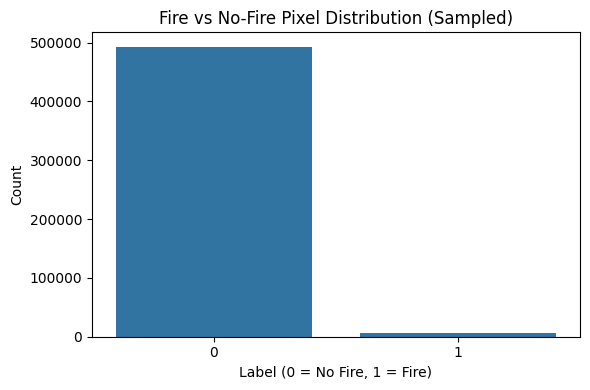

In [12]:
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load function ---
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# --- Load data ---
train_data   = load_pickle('data/next-day-wildfire-spread/train.data')    # (N, C, 64, 64)
train_labels = load_pickle('data/next-day-wildfire-spread/train.labels')  # (N, 64, 64)

# --- Feature names (will be trimmed if channels < names) ---
feature_names = [
    'elevation','fws','population','pdsi','pr','sph','slope','PrevFireMask',
    'erc','NDVI','fpr','ftemp','th','EVI','vs','tmmx','fwd','aspect','tmmn'
]

def build_df_for_eda(data, labels, feature_names, max_rows=500_000, seed=42,
                     oversample_fire=False, fire_target=0.20):
    """
    Build a pixel-level DataFrame without materializing the full (N*64*64, C).
    - Samples up to max_rows valid pixels (labels != -1).
    - Optionally oversamples fire pixels to reach fire_target proportion.
    Returns a pandas DataFrame with columns feature_names + 'Fire'.
    """
    rng = np.random.default_rng(seed)
    N, C, H, W = data.shape

    # Make sure feature_names matches channel count
    if len(feature_names) != C:
        feature_names = feature_names[:C]

    # 1) Valid pixel indices (exclude -1)
    labels_flat = labels.reshape(-1)
    valid_idx = np.where(labels_flat != -1)[0]
    if valid_idx.size == 0:
        raise ValueError("No valid labels (all are -1).")

    # 2) Choose which valid pixels to sample
    if not oversample_fire:
        k = min(max_rows, valid_idx.size)
        sel = rng.choice(valid_idx, size=k, replace=False)
    else:
        # Stratified sample to increase % of fire pixels in the sample
        y_valid = labels_flat[valid_idx]
        ones_idx  = valid_idx[y_valid == 1]
        zeros_idx = valid_idx[y_valid == 0]

        k = min(max_rows, valid_idx.size)
        k_ones  = min(len(ones_idx), int(k * fire_target))
        k_zeros = min(len(zeros_idx), k - k_ones)

        sel_parts = []
        if k_ones > 0:  sel_parts.append(rng.choice(ones_idx,  size=k_ones,  replace=False))
        if k_zeros > 0: sel_parts.append(rng.choice(zeros_idx, size=k_zeros, replace=False))

        sel = np.concatenate(sel_parts) if sel_parts else np.array([], dtype=valid_idx.dtype)
        if sel.size < k:
            remaining = np.setdiff1d(valid_idx, sel, assume_unique=False)
            top_up = rng.choice(remaining, size=k - sel.size, replace=False)
            sel = np.concatenate([sel, top_up])
        rng.shuffle(sel)

    # 3) Map flat indices -> (n, y, x)
    n_idx, y_idx, x_idx = np.unravel_index(sel, (N, H, W))

    # 4) Gather features and labels for sampled pixels
    X = data[n_idx, :, y_idx, x_idx].astype(np.float32, copy=False)  # (k, C)
    y = labels[n_idx, y_idx, x_idx].astype(np.int8, copy=False)      # (k,)

    # 5) Build the DataFrame used later in your EDA
    df = pd.DataFrame(X, columns=feature_names)
    df['Fire'] = y

    zeros = int((y == 0).sum())
    ones  = int((y == 1).sum())
    print(f"DataFrame built with {len(df):,} rows | Fire=1: {ones:,}, No-Fire=0: {zeros:,} | ratio (1:0) = {ones / max(1, zeros):.6f}")
    return df

# ---- Build df safely (natural distribution) ----
df = build_df_for_eda(
    train_data, train_labels, feature_names,
    max_rows=500_000,         # increase if you have more RAM
    seed=42,
    oversample_fire=False     # set True if you want more fire pixels for EDA
)

# ---- Plot: Fire vs No-Fire Distribution (lightweight) ----
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Fire'].astype(int))
plt.title("Fire vs No-Fire Pixel Distribution (Sampled)")
plt.xlabel("Label (0 = No Fire, 1 = Fire)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [13]:
num_zeros = (df['Fire'] == 0).sum()
num_ones = (df['Fire'] == 1).sum()

In [14]:
print(num_ones/num_zeros)

# Calculate ratio
if num_ones != 0:
    ratio = num_zeros / num_ones
    print(f"Ratio of 0s to 1s: {ratio:.3f} ({num_zeros}:{num_ones})")
else:
    print("No 1s found in the labels.")

0.014363385539235576
Ratio of 0s to 1s: 69.621 (492920:7080)


In [16]:
import numpy as np
import pandas as pd

def build_df_for_eda(data, labels, feature_names, sample_size=500_000, seed=42):
    """
    Create a pixel-level DataFrame from wildfire dataset without blowing memory.
    
    data: numpy array (N, C, H, W)
    labels: numpy array (N, H, W)
    feature_names: list of C feature names
    sample_size: number of pixels to sample for EDA
    """
    np.random.seed(seed)
    N, C, H, W = data.shape

    # Safety: match feature names to channel count
    if len(feature_names) != C:
        feature_names = feature_names[:C]

    # Mask out invalid labels (-1)
    labels_flat = labels.reshape(-1)
    valid_idx = np.where(labels_flat != -1)[0]

    # Randomly choose pixels to sample
    if sample_size < len(valid_idx):
        chosen_idx = np.random.choice(valid_idx, size=sample_size, replace=False)
    else:
        chosen_idx = valid_idx

    # Convert flat index → (n, y, x)
    n_idx, y_idx, x_idx = np.unravel_index(chosen_idx, (N, H, W))

    # Gather sampled features and labels
    X = data[n_idx, :, y_idx, x_idx]  # shape: (sample_size, C)
    y = labels[n_idx, y_idx, x_idx]

    # Create DataFrame
    df = pd.DataFrame(X, columns=feature_names)
    df["Fire"] = y.astype(int)

    print(f"DataFrame created with {len(df):,} pixels sampled from {len(valid_idx):,} valid pixels")
    return df

# Example usage:
train_data = np.load('data/next-day-wildfire-spread/train.data', allow_pickle=True)
train_labels = np.load('data/next-day-wildfire-spread/train.labels', allow_pickle = True)
feature_names = ['Feature1', 'Feature2', 'Feature3']  #
df = build_df_for_eda(train_data, train_labels, feature_names, sample_size=500_000)


ValueError: Shape of passed values is (500000, 19), indices imply (500000, 3)

In [6]:
print(train_data.shape)  # Should show (num_samples, 19, 64, 64)
print(len(feature_names))  # Should be 19


(24634, 19, 32, 32)
19


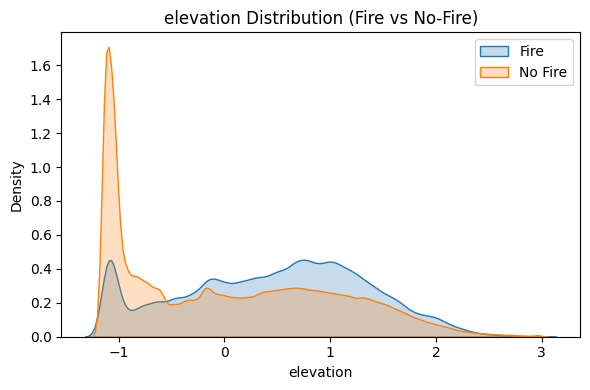

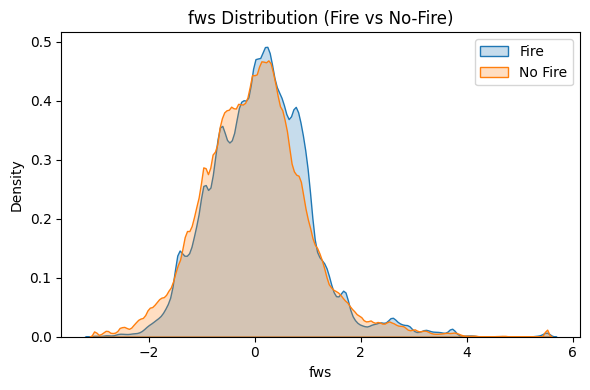

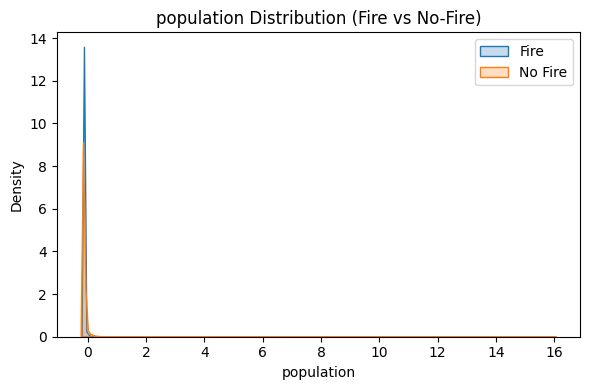

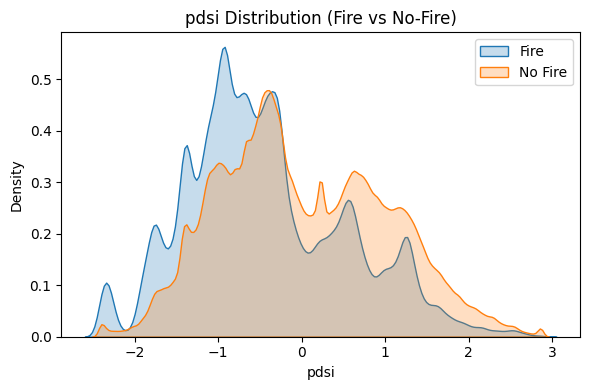

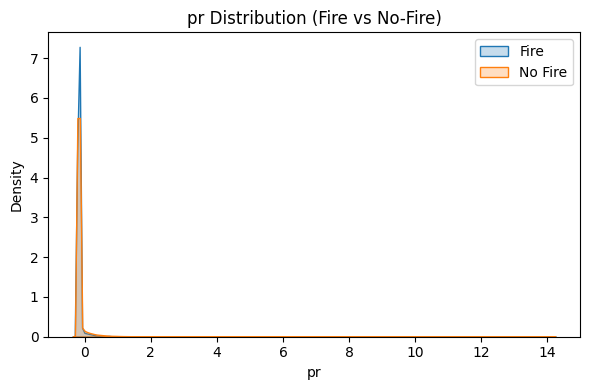

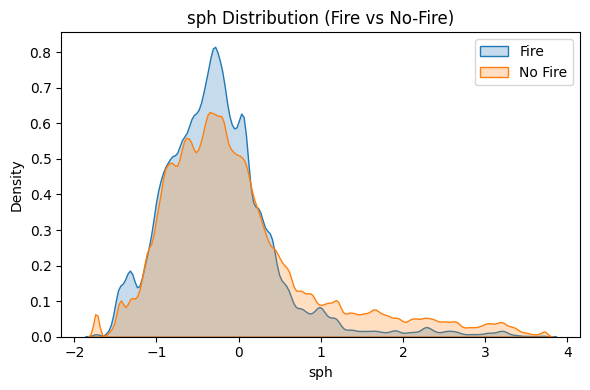

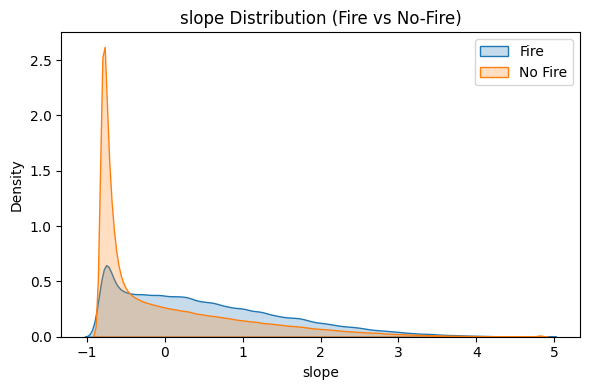

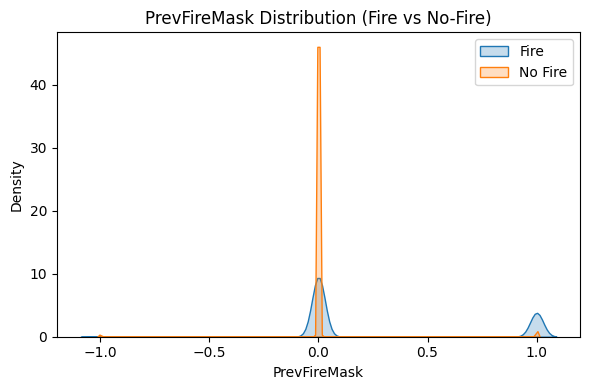

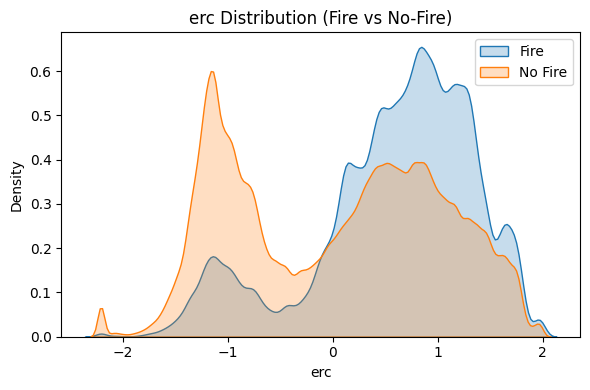

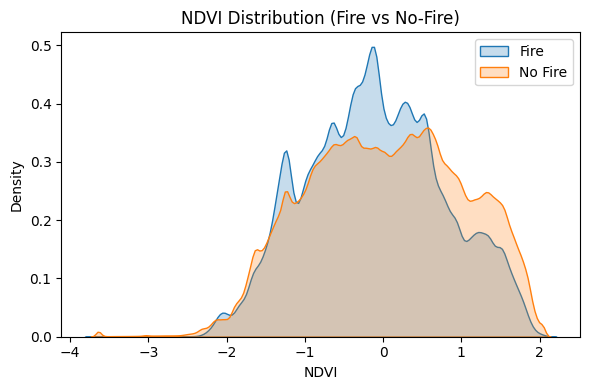

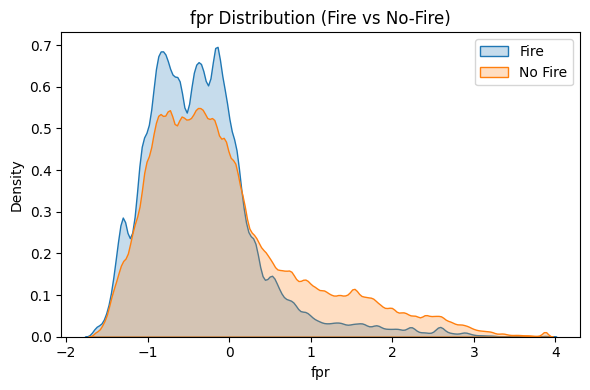

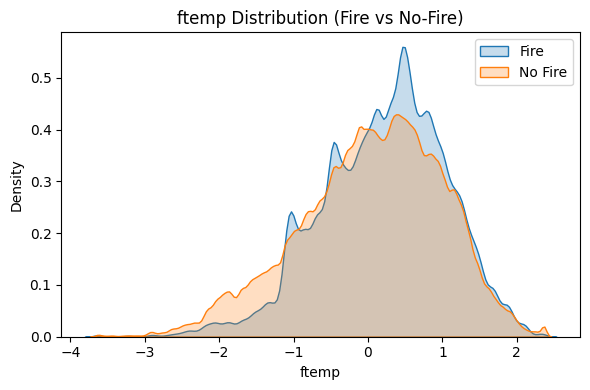

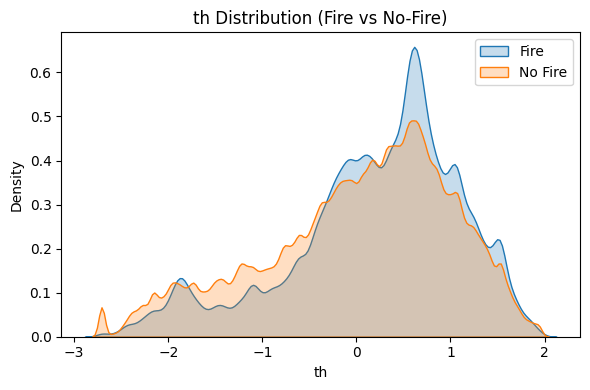

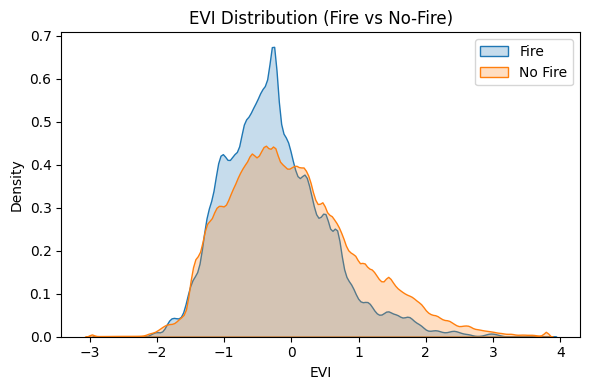

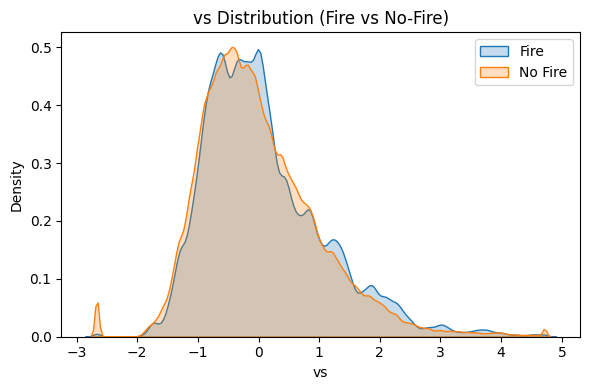

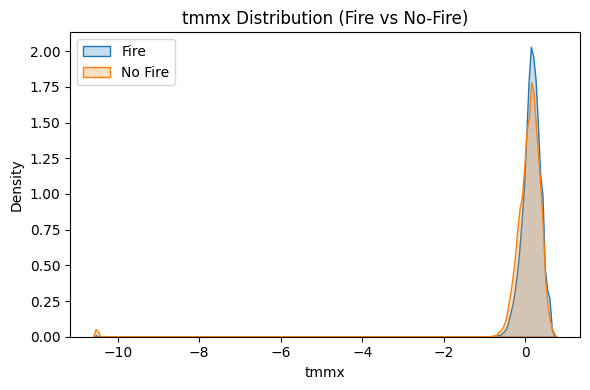

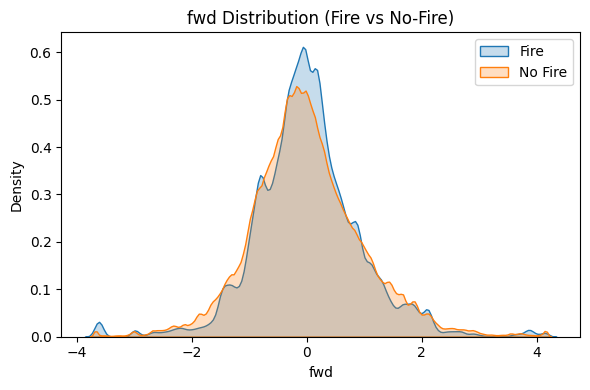

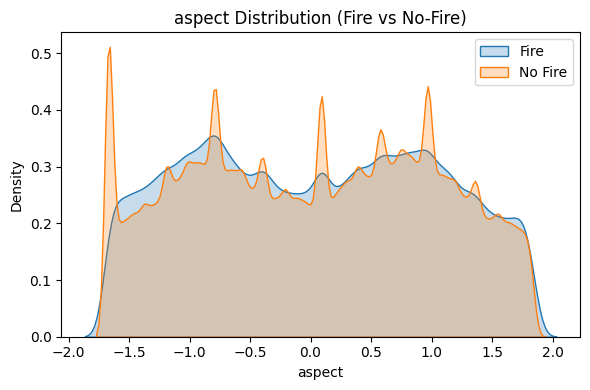

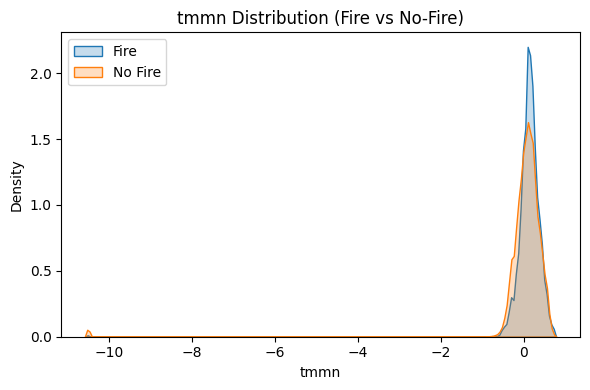

In [8]:

# 2. KDE plots for each feature
for feat in feature_names:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df[df['Fire'] == 1], x=feat, label='Fire', fill=True, common_norm=False)
    sns.kdeplot(data=df[df['Fire'] == 0], x=feat, label='No Fire', fill=True, common_norm=False)
    plt.title(f'{feat} Distribution (Fire vs No-Fire)')
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
# 3. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[feature_names].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()



In [ ]:
# 4. T-test
print("T-Test between Fire and No-Fire pixels:\n")
for feat in feature_names:
    fire_vals = df[df['Fire'] == 1][feat]
    nofire_vals = df[df['Fire'] == 0][feat]
    t_stat, p_val = ttest_ind(fire_vals, nofire_vals, equal_var=False)
    print(f"{feat:15s} | t = {t_stat:.3f}, p = {p_val:.3e}")



In [ ]:
# 5. Mutual Information
print("\nMutual Information between each feature and Fire label:\n")
for feat in feature_names:
    mi = mutual_info_score(df['Fire'], pd.qcut(df[feat], q=10, duplicates='drop'))
    print(f"{feat:15s} | MI = {mi:.4f}")




In [ ]:
# 6. PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[feature_names])
plt.figure(figsize=(6, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['Fire'], palette='coolwarm', s=10, alpha=0.5)
plt.title("PCA: 2D Projection of Features")
plt.tight_layout()
plt.show()



In [ ]:
# 7. t-SNE
sample_df = df.sample(n=5000, random_state=42)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(sample_df[feature_names])
plt.figure(figsize=(6, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=sample_df['Fire'], palette='coolwarm', s=10, alpha=0.6)
plt.title("t-SNE: Feature Projection")
plt.tight_layout()
plt.show()